# Loss Functions

Loss Functions meassure the distance between the predicted output and the desired output.

## Negative Log Likelihood Loss

The `nn.NLLLoss` function is typically used in combination with the `nn.LogSoftmax` activation function. 

### Likelihood

Given some **data** $X$ (the observed outcome) and a probability **distribution** $\theta$ (set of parameters that describe the stochastic process), then the **probability** $\text{P}(X|\theta)$ is the probability that we observe the outcome $X$ for a **fixed distribution** $\theta$.

However, when we model a real life stochastic process, we often do not know $\theta$. We simply observe $x$ and the goal then is to arrive at an estimate for $\theta$ that would be a plausible choice given the observed outcomes $x$. Thus **likelihood** $\text{L}(\theta|X)$ refers to the probability given a **fixed data** $X$ point with a distributions that can be moved.

Both are actually the same function, but seen from different perspectives and with $X$ and $\theta$ switching their roles as variable and parameter.

### Softmax

The Softmax function is used for **multi-class** problems (one of $k$ classes). Softmax squashes a vector of size $k$ between 0 and 1:

$$p_{x_i} = \frac{e^{x_i}}{\sum_j^k e^{x_j}}$$ 

In [242]:
import torch.nn as nn
softmax = nn.Softmax(dim=1)

y = torch.tensor([[2.0, 1.0, 0.1]])     # logits / scores
out = softmax(y)
out                                     # probabilities

tensor([[0.6590, 0.2424, 0.0986]])

### Maximum Likelihood Estimation

From a machine learning perspective, we are interested in determining the parameter $\theta$ from the training data. A possilbe method herefore is the **Maximum Likelihood Estimation** (MLE) procedure (we will refer to all possible parameters as $\theta$ and the estimated values as $\hat{\theta}$):

$$\hat{\theta} = \operatorname*{arg\,max}_{\theta} \text{L}(\theta | X) \quad \text{with} \quad X = x_1, \ldots, x_n$$

and 

$$\text{L}(\theta | X) = \prod_{x_i \in X} \text{P}(x_i | \theta)$$

### Negative Log Likelihood Loss

As multiplication of probabilities tend to be very small values, we take advantage of the fact, that $\log(a \cdot b) = \log(a) + \log(b)$ (that's the "**Log**"), that $\log(\text{P}) \in [-\infty, 0]$ (that's the "**Negative**") and that $\text{P}$ and $\log(\text{P})$ does not move the maximum (that's why it can be used as "**Loss**").

$$\text{L}_i = -\log(\prod_i^k p_i) = -\sum_i^k \log(p_i)$$

### PyTorch Example with NLLLoss()

Given a batch of three samples (e.g. images) with an softmax output for each of four possible classes $k$ and a one-hot encoded target:

In [243]:
import torch
import torch.nn as nn

# input values from last neuron
x = torch.tensor([[3.4, 1.2, -0.8, 3.1],
                  [0.4, 4.2, 3.8, -2.9],
                  [1.1, 2.9, 0.2, 4.2]], requires_grad=True)

# target
target_one_hot = torch.tensor([[1, 0, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])

_, target = target_one_hot.max(dim=1)          # transform one-hot-encoded target to a tensor of indexes: [0, 2, 3]


# probability scores (we want them big)
activation_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

out = activation_fn(x)
loss = loss_fn(out, target)
loss.backward()

print(loss)
print(x.grad)

tensor(0.6135, grad_fn=<NllLossBackward>)
tensor([[-1.5476e-01,  1.9787e-02,  2.6779e-03,  1.3229e-01],
        [ 4.4032e-03,  1.9683e-01, -2.0139e-01,  1.6240e-04],
        [ 1.1241e-02,  6.8002e-02,  4.5701e-03, -8.3813e-02]])


### PyTorch Example with custom Calculation

We calculate the negative log of the correct targeted softmaxed classes:

$(-log(0.2120) + -log(0.3162) + -log(0.4718)) \cdot \frac{1}{3} = -4.0198$


In [244]:
import torch
import torch.nn as nn

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).unsqueeze(1)
    

# input values from last neuron
x = torch.tensor([[3.4, 1.2, -0.8, 3.1],
                  [0.4, 4.2, 3.8, -2.9],
                  [1.1, 2.9, 0.2, 4.2]], requires_grad=True)

# target
target_one_hot = torch.tensor([[1, 0, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])

x_class = (softmax(x) * target_one_hot).sum(dim=1)        # softmax values of correct class
print(x_class)

#out_class = softmax(x_class[None])
#print(out_class)

loss_class = -torch.log(x_class)
print(loss_class.mean())


tensor([0.5357, 0.3958, 0.7486], grad_fn=<SumBackward1>)
tensor(0.6135, grad_fn=<MeanBackward0>)


# Calculation of the Loss in a Training Loop

When calculating the training- and validation-loss within a training loop, we typically have two loops: an **outer epoch loop** and an **inner batch loop**:

### Calculating loss in the inner batch loop

```python
batch_losses = []
for epoch in range(1, epochs + 1):
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # ...
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        batch_losses.append(train_loss)
```

Here, the train **loss** $L_n$ of an epoche is calculated as **recursive mean** of the $n$ **batch losses** $l_i$:

$$
\begin{aligned}
L_n &= \frac{1}{n} \sum_{i=1}^n l_i \qquad \qquad \text{and} \quad L_{n-1} = \frac{1}{n-1} \sum_{i=1}^{n-1} l_i\\
&= \frac{1}{n} \Big( l_n + \sum_{i=1}^{n-1} l_i \Big)\\
&= \frac{1}{n} \Big( l_n + \cdot L_{n-1} (n-1) \Big)\\
&= \frac{1}{n} \Big( l_n + n \, L_{n-1} - L_{n-1} \Big)\\
&= \frac{1}{n} \Big( n \, L_{n-1} + l_n - L_{n-1} \Big)\\
&= L_{n-1} + \frac{1}{n} \Big( l_n - L_{n-1} \Big)\\
\end{aligned}
$$

### Calculating loss in the outer epoch loop

The same value for the train **loss** $L_n$ of an epoche can be achieved by summing up each **batch loss** $l_i$ within the **inner batch loop**, but then calculating the **mean** of all batch losses of an epoche in the **outer epoch loop**.

```python
epoch_losses = []
for epoch in range(1, epochs + 1):
    train_loss = 0.0
    for data, target in train_loader:
        # ...
        train_loss = train_loss + loss.data
        
    train_loss = train_loss / len(train_loader)
    epoch_losses.append(train_loss)
```

### Example

Given a dataset of 1000 samples with random regression data between 0 and 1 based on a **linear regression** model $y = ax + b + \epsilon$.

In an experiment, we calculate the **train loss** for **each batch** and the train loss for **each epoch** and compare the loss history:

In [266]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

samples = 1000

x = torch.rand(samples)
y = 2 * x + 1 + (0.5 * torch.randn(samples))
dataset = TensorDataset(x.view(-1, 1), y.view(-1, 1))
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

model = nn.Sequential(nn.Linear(1, 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [267]:
epochs = 10
epoch_losses = []
batch_losses = []

for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        batch_losses.append(train_loss)

    epoch_losses.append(train_loss)

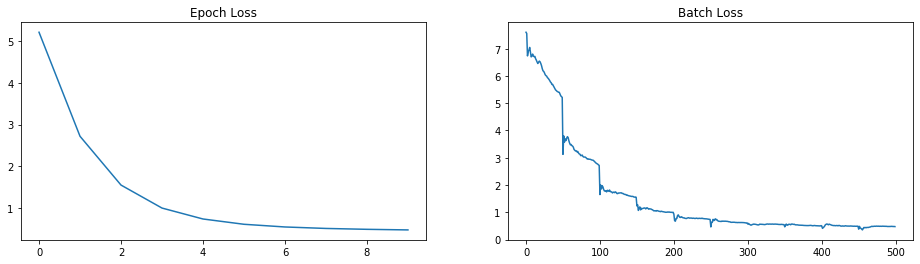

In [270]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.title('Epoch Loss')
plt.plot(epoch_losses)
plt.subplot(1,2,2)
plt.title('Batch Loss')
plt.plot(batch_losses);